In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import classification_report
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.applications import ResNet101V2
from keras.layers import Dense
from keras.models import Sequential

In [2]:
keras.utils.set_random_seed(13)

In [3]:
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()

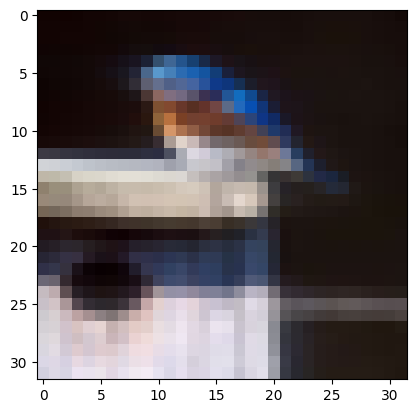

In [4]:
plt.imshow(X_train[13])

In [5]:
len(X_train), len(X_test)

(50000, 10000)

In [6]:
X_valid, X_test, y_valid, y_test = tts(X_test, y_test, test_size=0.2, random_state=13)

In [7]:
len(X_test), len(X_valid)

(2000, 8000)

In [8]:
X_train.shape

(50000, 32, 32, 3)

In [9]:
X_train = X_train/255
X_test = X_test/255
X_valid = X_valid/255

In [10]:
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)
y_valid = keras.utils.to_categorical(y_valid, 10)

In [11]:
X_dataset_train = tf.data.Dataset.from_tensor_slices(X_train)
y_dataset_train = tf.data.Dataset.from_tensor_slices(y_train)

dataset_train = tf.data.Dataset.zip((X_dataset_train, y_dataset_train))

2024-01-05 22:54:05.550603: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-01-05 22:54:05.550628: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-01-05 22:54:05.550633: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-01-05 22:54:05.550665: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-05 22:54:05.550677: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [12]:
X_dataset_valid = tf.data.Dataset.from_tensor_slices(X_valid)
y_dataset_valid = tf.data.Dataset.from_tensor_slices(y_valid)

dataset_valid = tf.data.Dataset.zip((X_dataset_valid, y_dataset_valid))

In [13]:
dataset_train = dataset_train.shuffle(500).batch(256).prefetch(tf.data.experimental.AUTOTUNE)
dataset_valid = dataset_valid.shuffle(500).batch(256).prefetch(tf.data.experimental.AUTOTUNE)

In [14]:
X_dataset_test = tf.data.Dataset.from_tensor_slices(X_test)
y_dataset_test = tf.data.Dataset.from_tensor_slices(y_test)

dataset_test = tf.data.Dataset.zip((X_dataset_test, y_dataset_test))
dataset_test = dataset_test.shuffle(500).batch(256).prefetch(tf.data.experimental.AUTOTUNE)

# Эксперимент 1
- Набросал простую модель, это будет наш бейзлайн

In [15]:
first_model = Sequential()

first_model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
first_model.add(Conv2D(filters=64, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
first_model.add(MaxPool2D(pool_size=(2, 2)))
first_model.add(Flatten())
first_model.add(Dense(128, activation='relu'))
first_model.add(Dense(10, activation='softmax'))

metrics = [
    tf.keras.metrics.F1Score(name='f1'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]
first_model.compile(loss='categorical_crossentropy', 
              optimizer='RMSprop', 
              metrics=metrics)

In [16]:
history = first_model.fit(dataset_train, 
                          epochs=10,
                          validation_data=dataset_valid,
                          callbacks=tf.keras.callbacks.TensorBoard(log_dir='models/exp1_logs'))

Epoch 1/10


2024-01-05 22:54:07.264109: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


196/196 [==============================] - 25s 101ms/step - loss: 1.7589 - f1: 0.3866 - precision: 0.6509 - recall: 0.1483 - val_loss: 1.4649 - val_f1: 0.4760 - val_precision: 0.6688 - val_recall: 0.2640
Epoch 2/10
196/196 [==============================] - 13s 65ms/step - loss: 1.2644 - f1: 0.5609 - precision: 0.7286 - recall: 0.3769 - val_loss: 1.3939 - val_f1: 0.5204 - val_precision: 0.6440 - val_recall: 0.3907
Epoch 3/10
196/196 [==============================] - 13s 66ms/step - loss: 1.1156 - f1: 0.6129 - precision: 0.7417 - recall: 0.4830 - val_loss: 1.4604 - val_f1: 0.5343 - val_precision: 0.6314 - val_recall: 0.4584
Epoch 4/10
196/196 [==============================] - 13s 64ms/step - loss: 1.0552 - f1: 0.6402 - precision: 0.7396 - recall: 0.5459 - val_loss: 1.4351 - val_f1: 0.5279 - val_precision: 0.6011 - val_recall: 0.4811
Epoch 5/10
196/196 [==============================] - 13s 65ms/step - loss: 1.1168 - f1: 0.6413 - precision: 0.7107 - recall: 0.5804 - val_loss: 1.4106 - 

In [17]:
eval_hist = first_model.evaluate(dataset_test)

8/8 [==============================] - 1s 205ms/step - loss: 5.2141 - f1: 0.4618 - precision: 0.4735 - recall: 0.4640


In [18]:
print("Eval_loss = {} \nEval_f1 = {} \nEval_precision = {} \nEval_recall = {}".format(eval_hist[0], 
                                                                                      eval_hist[1], 
                                                                                      eval_hist[2],
                                                                                      eval_hist[3]))

Eval_loss = 5.214085102081299 
Eval_f1 = [0.54019296 0.39711195 0.46492985 0.39002934 0.39322037 0.15609755
 0.53658533 0.5797101  0.6590257  0.50061053] 
Eval_precision = 0.4734693765640259 
Eval_recall = 0.46399998664855957


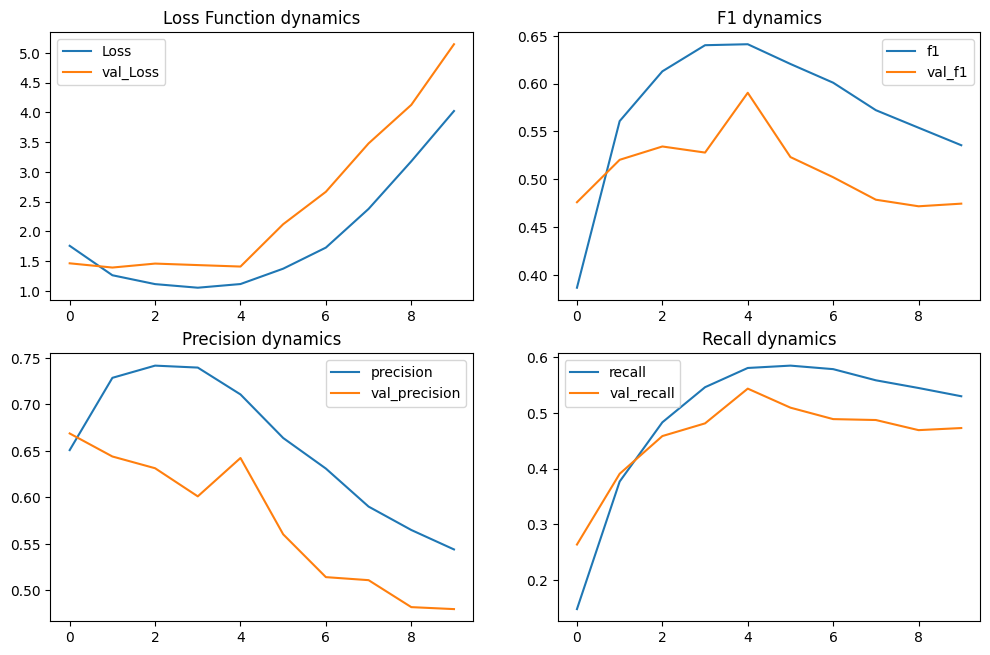

In [19]:
plt.figure(figsize=(12, 16))

plt.subplot(4, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='val_Loss')
plt.title('Loss Function dynamics')
plt.legend()

plt.subplot(4, 2, 2)
plt.plot((np.mean(history.history['f1'],axis = 1)), label='f1')
plt.plot((np.mean(history.history['val_f1'],axis = 1)), label='val_f1')
plt.title('F1 dynamics')
plt.legend()

plt.subplot(4, 2, 3)
plt.plot(history.history['precision'], label='precision')
plt.plot(history.history['val_precision'], label='val_precision')
plt.title('Precision dynamics')
plt.legend()

plt.subplot(4, 2, 4)
plt.plot(history.history['recall'], label='recall')
plt.plot(history.history['val_recall'], label='val_recall')
plt.title('Recall dynamics')
plt.legend()

In [20]:
first_preds = first_model.predict(X_valid)

250/250 [==============================] - 1s 2ms/step


In [21]:
first_preds = np.argmax(first_preds, axis=1)
y_valid_idx = np.argmax(y_valid, axis=1)

In [22]:
print(classification_report(y_valid_idx, first_preds))

              precision    recall  f1-score   support

           0       0.81      0.37      0.50       783
           1       0.84      0.31      0.45       794
           2       0.39      0.57      0.46       786
           3       0.29      0.70      0.41       799
           4       0.67      0.32      0.44       810
           5       0.79      0.11      0.20       811
           6       0.85      0.36      0.51       801
           7       0.85      0.46      0.59       820
           8       0.80      0.63      0.71       810
           9       0.31      0.95      0.47       786

    accuracy                           0.48      8000
   macro avg       0.66      0.48      0.47      8000
weighted avg       0.66      0.48      0.47      8000



Text(0.5, 1.0, 'Predicted class:8  Real class:8')

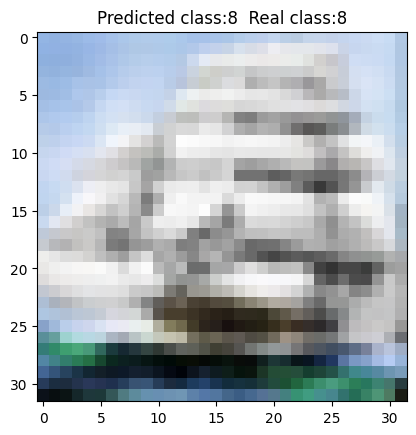

In [23]:
i = 1
plt.imshow(X_valid[i])
plt.title('Predicted class:'+str(first_preds[i])+'  Real class:'+str(y_valid_idx[i]))

In [24]:
first_model.save('models/exp_1.keras')

# Эксперимент 2
- Усложним архитектуру, добавим сверточных слоев, дропаут, батчнорм
- попробуем другой оптимизатор `Adam`
- добавим early-stop

In [25]:
second_model = Sequential()

second_model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
second_model.add(BatchNormalization())
second_model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
second_model.add(BatchNormalization())
second_model.add(MaxPool2D(pool_size=(2, 2)))
second_model.add(Dropout(0.25))
second_model.add(Conv2D(filters=64, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
second_model.add(BatchNormalization())
second_model.add(Conv2D(filters=64, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
second_model.add(BatchNormalization())
second_model.add(MaxPool2D(pool_size=(2, 2)))
second_model.add(Dropout(0.25))
second_model.add(Conv2D(filters=128, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
second_model.add(BatchNormalization())
second_model.add(Conv2D(filters=128, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
second_model.add(BatchNormalization())
second_model.add(MaxPool2D(pool_size=(2, 2)))
second_model.add(Dropout(0.25))
second_model.add(Flatten())
second_model.add(Dense(128, activation='relu'))
second_model.add(Dropout(0.25))
second_model.add(Dense(10, activation='softmax'))

metrics = [
    tf.keras.metrics.F1Score(name='f1'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]
second_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=metrics)

In [26]:
learn_rate_red=keras.callbacks.ReduceLROnPlateau("val_loss", patience=3, factor = 0.5, min_lr=1e-4)
early_stop = keras.callbacks.EarlyStopping("val_loss", patience=4)
tensorboard = tf.keras.callbacks.TensorBoard(log_dir="models/exp2_logs")

In [27]:
history = second_model.fit(dataset_train, 
                           epochs=20,
                           validation_data=dataset_valid,
                           callbacks=[learn_rate_red, early_stop, tensorboard])

Epoch 1/20
196/196 [==============================] - 29s 120ms/step - loss: 5.2225 - f1: 0.2859 - precision: 0.2951 - recall: 0.2704 - val_loss: 4.5349 - val_f1: 0.0595 - val_precision: 0.1344 - val_recall: 0.1163 - lr: 0.0010
Epoch 2/20
196/196 [==============================] - 17s 85ms/step - loss: 2.7845 - f1: 0.4334 - precision: 0.4616 - recall: 0.4079 - val_loss: 3.6441 - val_f1: 0.1482 - val_precision: 0.2492 - val_recall: 0.2059 - lr: 0.0010
Epoch 3/20
196/196 [==============================] - 16s 80ms/step - loss: 1.7388 - f1: 0.5396 - precision: 0.5876 - recall: 0.5016 - val_loss: 1.2879 - val_f1: 0.6090 - val_precision: 0.6743 - val_recall: 0.5443 - lr: 0.0010
Epoch 4/20
196/196 [==============================] - 16s 80ms/step - loss: 1.3412 - f1: 0.6003 - precision: 0.6607 - recall: 0.5544 - val_loss: 1.0229 - val_f1: 0.6711 - val_precision: 0.7380 - val_recall: 0.6248 - lr: 0.0010
Epoch 5/20
196/196 [==============================] - 16s 79ms/step - loss: 1.1632 - f1: 0.

In [28]:
eval_hist = second_model.evaluate(dataset_test)

8/8 [==============================] - 2s 267ms/step - loss: 0.6514 - f1: 0.7942 - precision: 0.8303 - recall: 0.7705


In [29]:
print("Eval_loss = {} \nEval_f1 = {} \nEval_precision = {} \nEval_recall = {}".format(eval_hist[0], 
                                                                                      eval_hist[1], 
                                                                                      eval_hist[2],
                                                                                      eval_hist[3]))

Eval_loss = 0.6514220237731934 
Eval_f1 = [0.856492   0.9116945  0.6442578  0.6058981  0.72444445 0.70080864
 0.8243243  0.8653295  0.90026957 0.9086651 ] 
Eval_precision = 0.8302801847457886 
Eval_recall = 0.7705000042915344


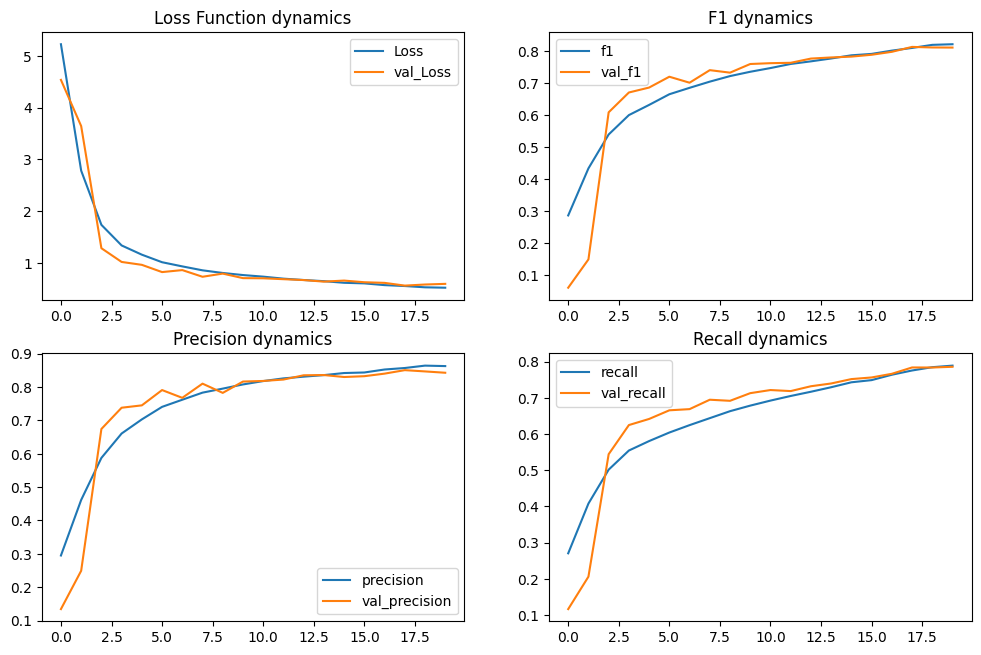

In [30]:
plt.figure(figsize=(12, 16))

plt.subplot(4, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='val_Loss')
plt.title('Loss Function dynamics')
plt.legend()

plt.subplot(4, 2, 2)
plt.plot((np.mean(history.history['f1'],axis = 1)), label='f1')
plt.plot((np.mean(history.history['val_f1'],axis = 1)), label='val_f1')
plt.title('F1 dynamics')
plt.legend()

plt.subplot(4, 2, 3)
plt.plot(history.history['precision'], label='precision')
plt.plot(history.history['val_precision'], label='val_precision')
plt.title('Precision dynamics')
plt.legend()

plt.subplot(4, 2, 4)
plt.plot(history.history['recall'], label='recall')
plt.plot(history.history['val_recall'], label='val_recall')
plt.title('Recall dynamics')
plt.legend()

In [31]:
second_preds = second_model.predict(X_test)
second_preds = np.argmax(second_preds, axis=1)
y_test_idx = np.argmax(y_test, axis=1)

63/63 [==============================] - 1s 13ms/step


In [32]:
print(classification_report(y_test_idx, second_preds))

              precision    recall  f1-score   support

           0       0.85      0.87      0.86       217
           1       0.90      0.93      0.91       206
           2       0.80      0.54      0.64       214
           3       0.66      0.56      0.61       201
           4       0.63      0.86      0.72       190
           5       0.71      0.69      0.70       189
           6       0.75      0.92      0.82       199
           7       0.89      0.84      0.87       180
           8       0.92      0.88      0.90       190
           9       0.91      0.91      0.91       214

    accuracy                           0.80      2000
   macro avg       0.80      0.80      0.79      2000
weighted avg       0.80      0.80      0.79      2000



Text(0.5, 1.0, 'Predicted class:0  Real class:0')

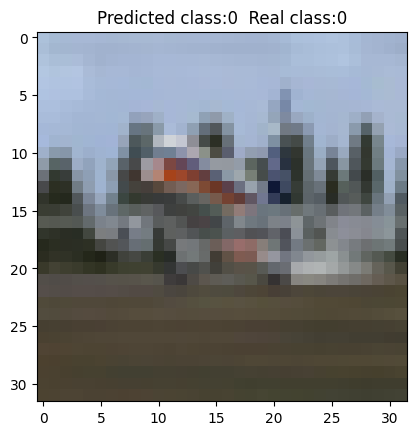

In [33]:
i = 4
plt.imshow(X_test[i])
plt.title('Predicted class:'+str(second_preds[i])+'  Real class:'+str(y_test_idx[i]))

In [35]:
second_model.save('models/exp_2.keras')

# Эксперимент 3
- обучим архитектуру ResNet

In [39]:
resnet = Sequential()
base_model = ResNet101V2(input_shape=(32, 32, 3), include_top=False, weights='imagenet', pooling='avg')
resnet.add(base_model)
resnet.add(Dense(10, activation='softmax'))
resnet.compile(loss='categorical_crossentropy', optimizer='adam', metrics=metrics)
history = resnet.fit(dataset_train,
                     epochs=15,
                     validation_data=dataset_valid,
                     callbacks=[learn_rate_red, early_stop, 
                                tf.keras.callbacks.TensorBoard(log_dir="models/exp3_logs")])

171317808/171317808 [==============================] - 49s 0us/step
Epoch 1/15
196/196 [==============================] - 208s 800ms/step - loss: 1.8290 - f1: 0.3424 - precision: 0.7294 - recall: 0.1630 - val_loss: 8.2518 - val_f1: 0.2762 - val_precision: 0.3280 - val_recall: 0.2824 - lr: 0.0010
Epoch 2/15
196/196 [==============================] - 99s 503ms/step - loss: 1.0516 - f1: 0.6583 - precision: 0.7868 - recall: 0.5321 - val_loss: 4657.3867 - val_f1: 0.2396 - val_precision: 0.2754 - val_recall: 0.2220 - lr: 0.0010
Epoch 3/15
196/196 [==============================] - 98s 500ms/step - loss: 1.1251 - f1: 0.6491 - precision: 0.7754 - recall: 0.5234 - val_loss: 5.0052 - val_f1: 0.6247 - val_precision: 0.6612 - val_recall: 0.5587 - lr: 0.0010
Epoch 4/15
196/196 [==============================] - 98s 498ms/step - loss: 0.8290 - f1: 0.7303 - precision: 0.8215 - recall: 0.6440 - val_loss: 0.9695 - val_f1: 0.6853 - val_precision: 0.7717 - val_recall: 0.6200 - lr: 0.0010
Epoch 5/15
196/1

In [40]:
eval_hist = resnet.evaluate(dataset_test)

8/8 [==============================] - 17s 2s/step - loss: 1.1268 - f1: 0.7527 - precision: 0.7653 - recall: 0.7450


In [41]:
print("Eval_loss = {} \nEval_f1 = {} \nEval_precision = {} \nEval_recall = {}".format(eval_hist[0], 
                                                                                      eval_hist[1], 
                                                                                      eval_hist[2],
                                                                                      eval_hist[3]))

Eval_loss = 1.1268038749694824 
Eval_f1 = [0.8061002  0.8341709  0.67733335 0.58064514 0.6733668  0.6428571
 0.8310249  0.80547947 0.8329048  0.8434783 ] 
Eval_precision = 0.7652798891067505 
Eval_recall = 0.7450000047683716


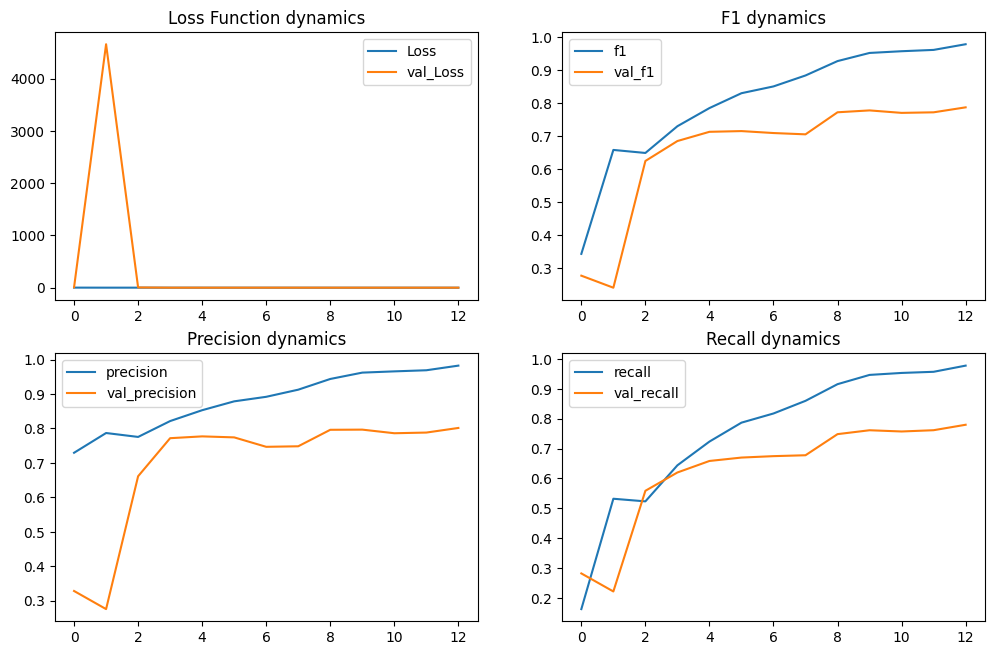

In [42]:
plt.figure(figsize=(12, 16))

plt.subplot(4, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='val_Loss')
plt.title('Loss Function dynamics')
plt.legend()

plt.subplot(4, 2, 2)
plt.plot((np.mean(history.history['f1'],axis = 1)), label='f1')
plt.plot((np.mean(history.history['val_f1'],axis = 1)), label='val_f1')
plt.title('F1 dynamics')
plt.legend()

plt.subplot(4, 2, 3)
plt.plot(history.history['precision'], label='precision')
plt.plot(history.history['val_precision'], label='val_precision')
plt.title('Precision dynamics')
plt.legend()

plt.subplot(4, 2, 4)
plt.plot(history.history['recall'], label='recall')
plt.plot(history.history['val_recall'], label='val_recall')
plt.title('Recall dynamics')
plt.legend()

In [43]:
resnet_preds = resnet.predict(X_test)
resnet_preds = np.argmax(resnet_preds, axis=1)
y_test_idx = np.argmax(y_test, axis=1)

63/63 [==============================] - 28s 251ms/step


In [44]:
print(classification_report(y_test_idx, resnet_preds))

              precision    recall  f1-score   support

           0       0.76      0.85      0.81       217
           1       0.86      0.81      0.83       206
           2       0.79      0.59      0.68       214
           3       0.58      0.58      0.58       201
           4       0.64      0.71      0.67       190
           5       0.62      0.67      0.64       189
           6       0.93      0.75      0.83       199
           7       0.79      0.82      0.81       180
           8       0.81      0.85      0.83       190
           9       0.79      0.91      0.84       214

    accuracy                           0.75      2000
   macro avg       0.76      0.75      0.75      2000
weighted avg       0.76      0.75      0.75      2000



Text(0.5, 1.0, 'Predicted class:4  Real class:4')

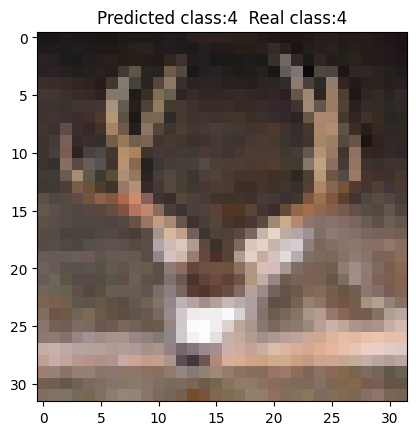

In [47]:
i = 8
plt.imshow(X_test[i])
plt.title('Predicted class:'+str(resnet_preds[i])+'  Real class:'+str(y_test_idx[i]))

In [48]:
resnet.save('models/exp_3_resnet.keras')

## Итоги
Лучшие метрики получились у кастомной модели из второго эксперимента

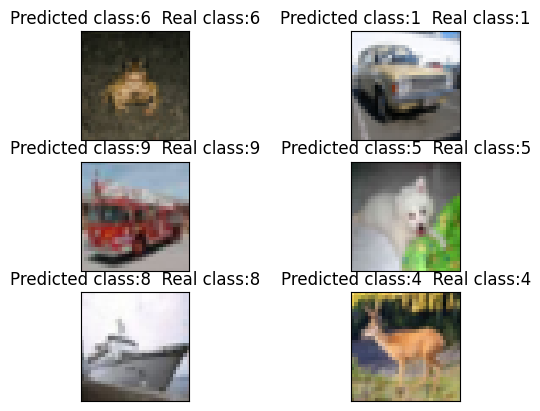

In [53]:
h, w = (2, 3)
fig, axs = plt.subplots(w, h)
for i in range(w):
    for j in range(h):
        num = np.random.randint(2000)
        axs[i, j].imshow(X_test[num])
        axs[i, j].set_title('Predicted class:'+str(second_preds[num])+'  Real class:'+str(y_test_idx[num]))
        axs[i, j].set(xticks=[], yticks=[])